Have a look later at multiparallel forecasting:
 https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/
 
 also interesting:
 https://www.youtube.com/watch?v=nMkqWxMjWzg&ab_channel=PyData
 ## CLEARLY THERE MIGHT BE AN ISSUE IN TRAINING ON PCTC DATA. MASE DOESNT MAKE SENSE WITH THAT AND PROBABLY LOSING INFORMATION
 

In [17]:
from backend.models.model_nnext import ModelNNext
from configs.config import get_cfg
import matplotlib.pyplot as plt
import numpy as np

In [18]:
convolution = True

In [19]:
if convolution:
    cfg = get_cfg("model_finance_convo.yaml")
else:
    cfg = get_cfg("model_finance.yaml")
# Instantiate and print the model
model = ModelNNext(cfg, flat_input = not convolution)
model.prepare_data()

[*********************100%***********************]  5 of 5 completed


In [13]:
import pickle
with open('data-loaded_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [20]:
import pickle
with open('data-loaded_model.pkl', 'rb') as file:
    model = pickle.load(file)
model.cfg = get_cfg("model_finance_convo.yaml")

In [21]:
model.build()

In [29]:
# model.model.n_epochs = 2000
# model.model.max_number_of_increase = 10000
model.train(verbose = 1)

Epoch: 0
Train - Loss: 0.7976
Valid - Loss: 1.3917
Epoch: 1
Train - Loss: 0.7999
Valid - Loss: 1.4127
Epoch: 2
Train - Loss: 0.8042
Valid - Loss: 1.4377
Epoch: 3
Train - Loss: 0.8161
Valid - Loss: 1.3776
Epoch: 4
Train - Loss: 0.8148
Valid - Loss: 1.4481
Epoch: 5
Train - Loss: 0.7970
Valid - Loss: 1.3794
Epoch: 6
Train - Loss: 0.7834
Valid - Loss: 1.4117
Epoch: 7
Train - Loss: 0.7750
Valid - Loss: 1.4068
Epoch: 8
Train - Loss: 0.7723
Valid - Loss: 1.3855
Epoch: 9
Train - Loss: 0.7811
Valid - Loss: 1.4469
Epoch: 10
Train - Loss: 0.7975
Valid - Loss: 1.3857
Epoch: 11
Train - Loss: 0.8020
Valid - Loss: 1.4271
Epoch: 12
Train - Loss: 0.7924
Valid - Loss: 1.3980
Epoch: 13
Train - Loss: 0.7834
Valid - Loss: 1.3955
Epoch: 14
Train - Loss: 0.7793
Valid - Loss: 1.4117
Epoch: 15
Train - Loss: 0.7753
Valid - Loss: 1.3895
Epoch: 16
Train - Loss: 0.7806
Valid - Loss: 1.4304
Epoch: 17
Train - Loss: 0.7895
Valid - Loss: 1.3805
Epoch: 18
Train - Loss: 0.7969
Valid - Loss: 1.4468
Epoch: 19
Train - Loss

tensor(1.4114)

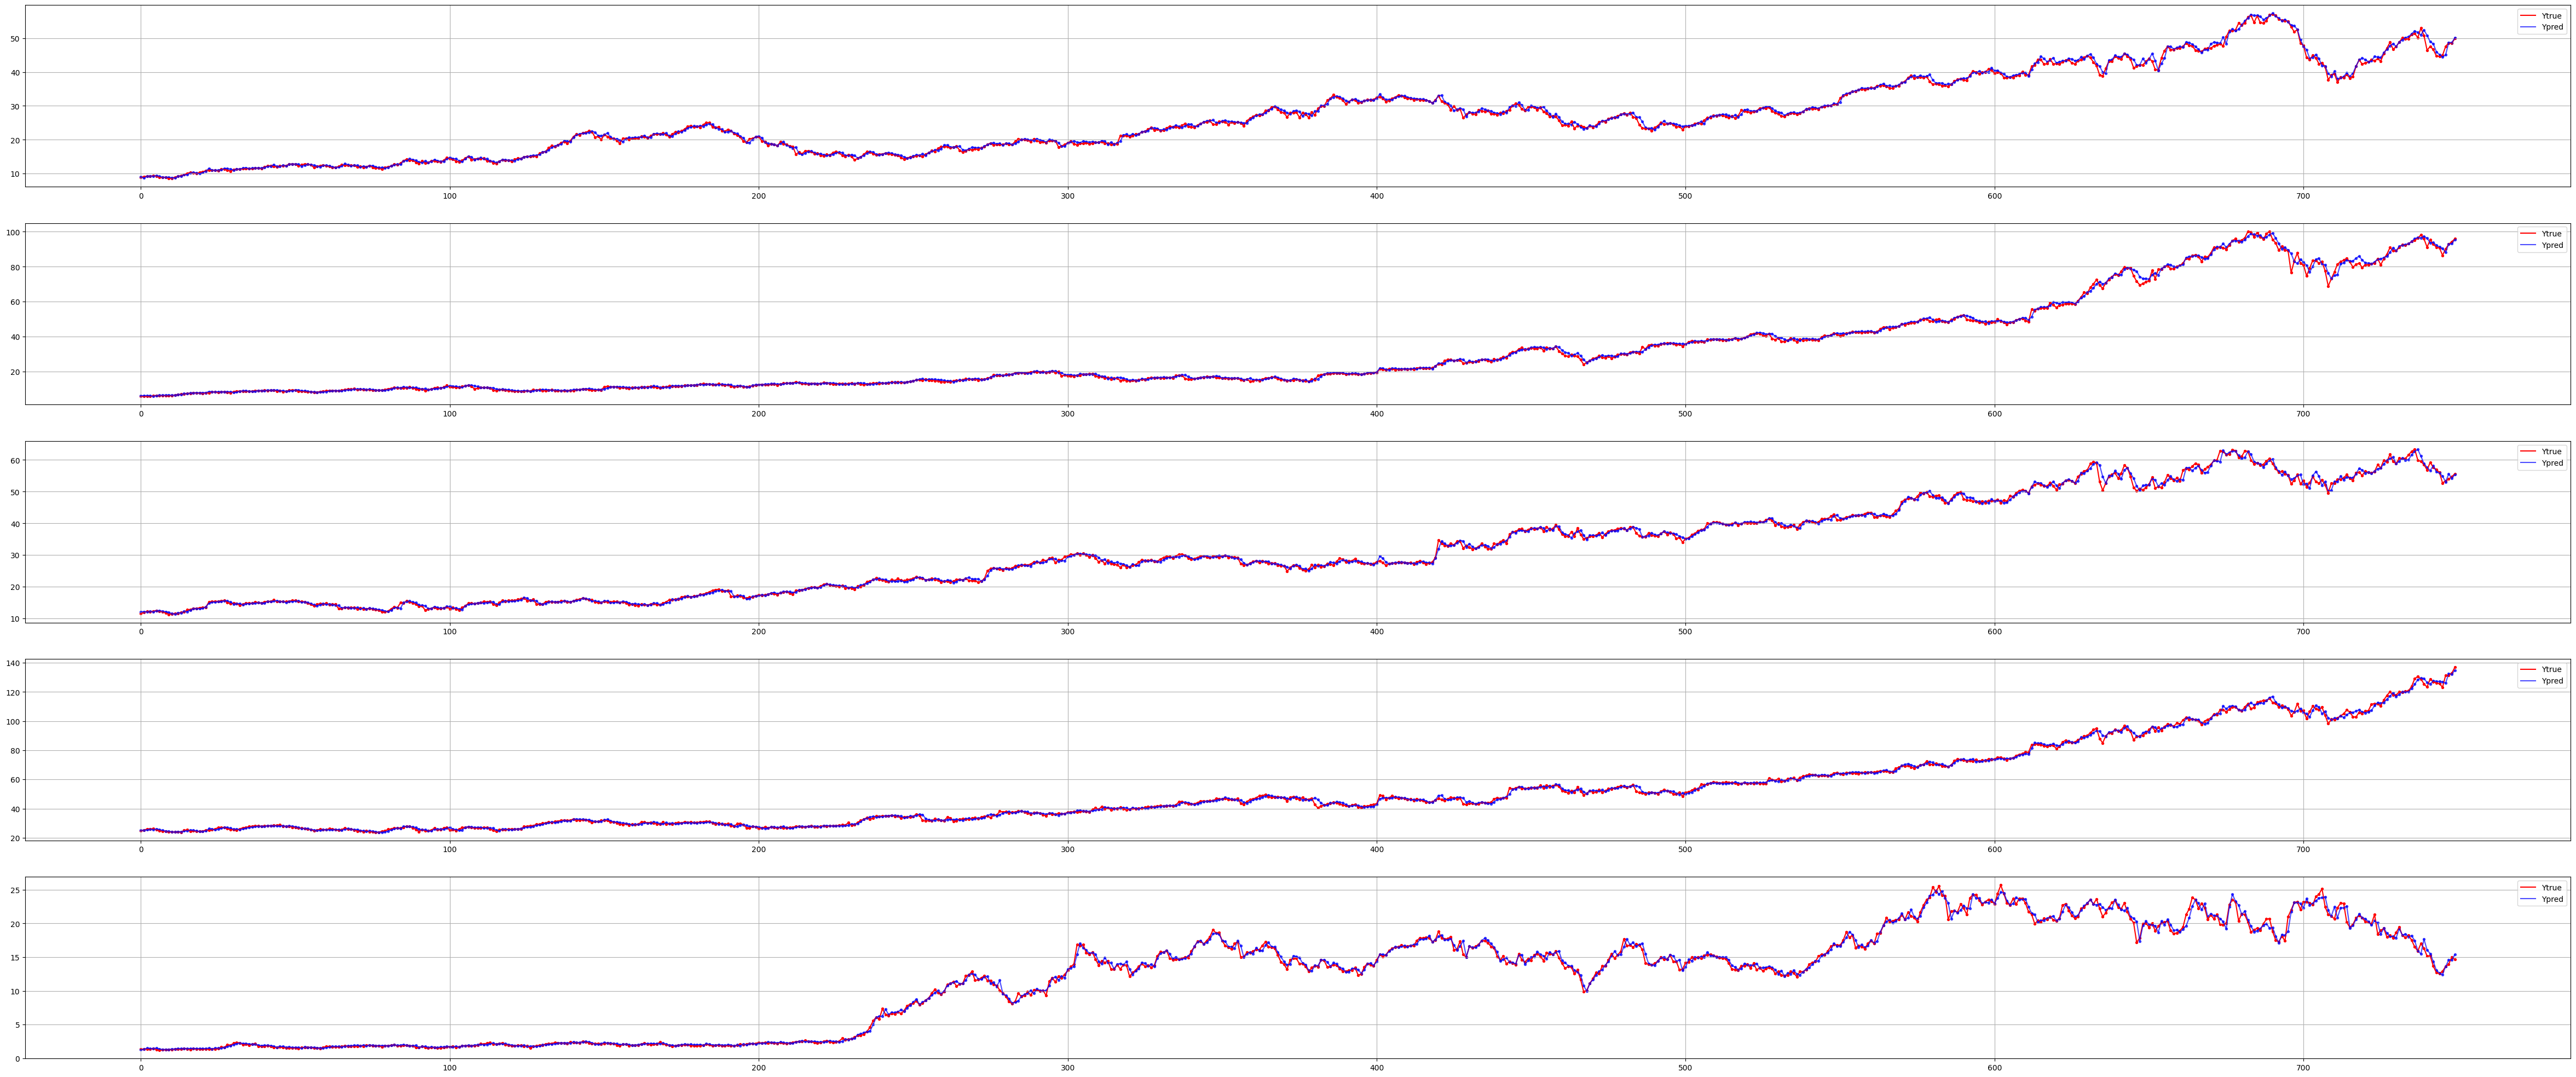

In [30]:
### TRAINING CHECKS
# Calculate percentage change
def pctc(arr):
  return np.diff(arr,axis = 0) / arr[:-1,:] * 100

# if convolution:
#     # Ypred = model.evaluate(model.data.X_test_set.tensor.unsqueeze(1)).numpy()
#     Ypred_pctc = model.evaluate(model.data.X_test_set.tensorT).numpy().copy()
# else:
#     Ypred_pctc = model.evaluate(model.data.X_test_set.reshaped_2D_tensor()).numpy().copy()
# Ytrue_pctc = model.data.Y_test_set.ndarray.copy()
# floorYtest = model.data.Ybis_test_set.ndarray.copy()

# Ypred= (Ypred_pctc/100.+1.)*floorYtest
# Ytrue= (Ytrue_pctc/100.+1.)*floorYtest
# ### it is very different from inverting pctc (since it guesses the future...)

if convolution:
    # Ypred = model.evaluate(model.data.X_test_set.tensor.unsqueeze(1)).numpy()
    Ypred = model.evaluate(model.data.X_train_set.tensorT).numpy().copy()*model.data.scal_buffer_train
else:
    Ypred= model.evaluate(model.data.X_train_set.reshaped_2D_tensor()).numpy().copy()*model.data.scal_buffer_train
Ytrue = model.data.Y_train_set.ndarray.copy()*model.data.scal_buffer_train

# Assuming Ypred and Ytrue are 2D arrays with shape (n_samples, n_curves)
n_curves = len(Ypred[0])
n_samples = len(Ypred)

t = np.arange(n_samples)

# Create a subplot
fig, ax = plt.subplots(n_curves,1,figsize=(60,25))

# Plot the first set (Ypred) in blue
for i in range(n_curves):
    ax[i].plot(t, Ytrue[:, i], color='red', label='Ytrue')
    ax[i].scatter(t, Ytrue[:, i], color='red', s= 8)
    ax[i].plot(t, Ypred[:, i], color='blue', label='Ypred',alpha = 0.7)
    ax[i].scatter(t, Ypred[:, i], color='blue', s= 8,alpha = 0.7)
    ax[i].legend()
    ax[i].grid()

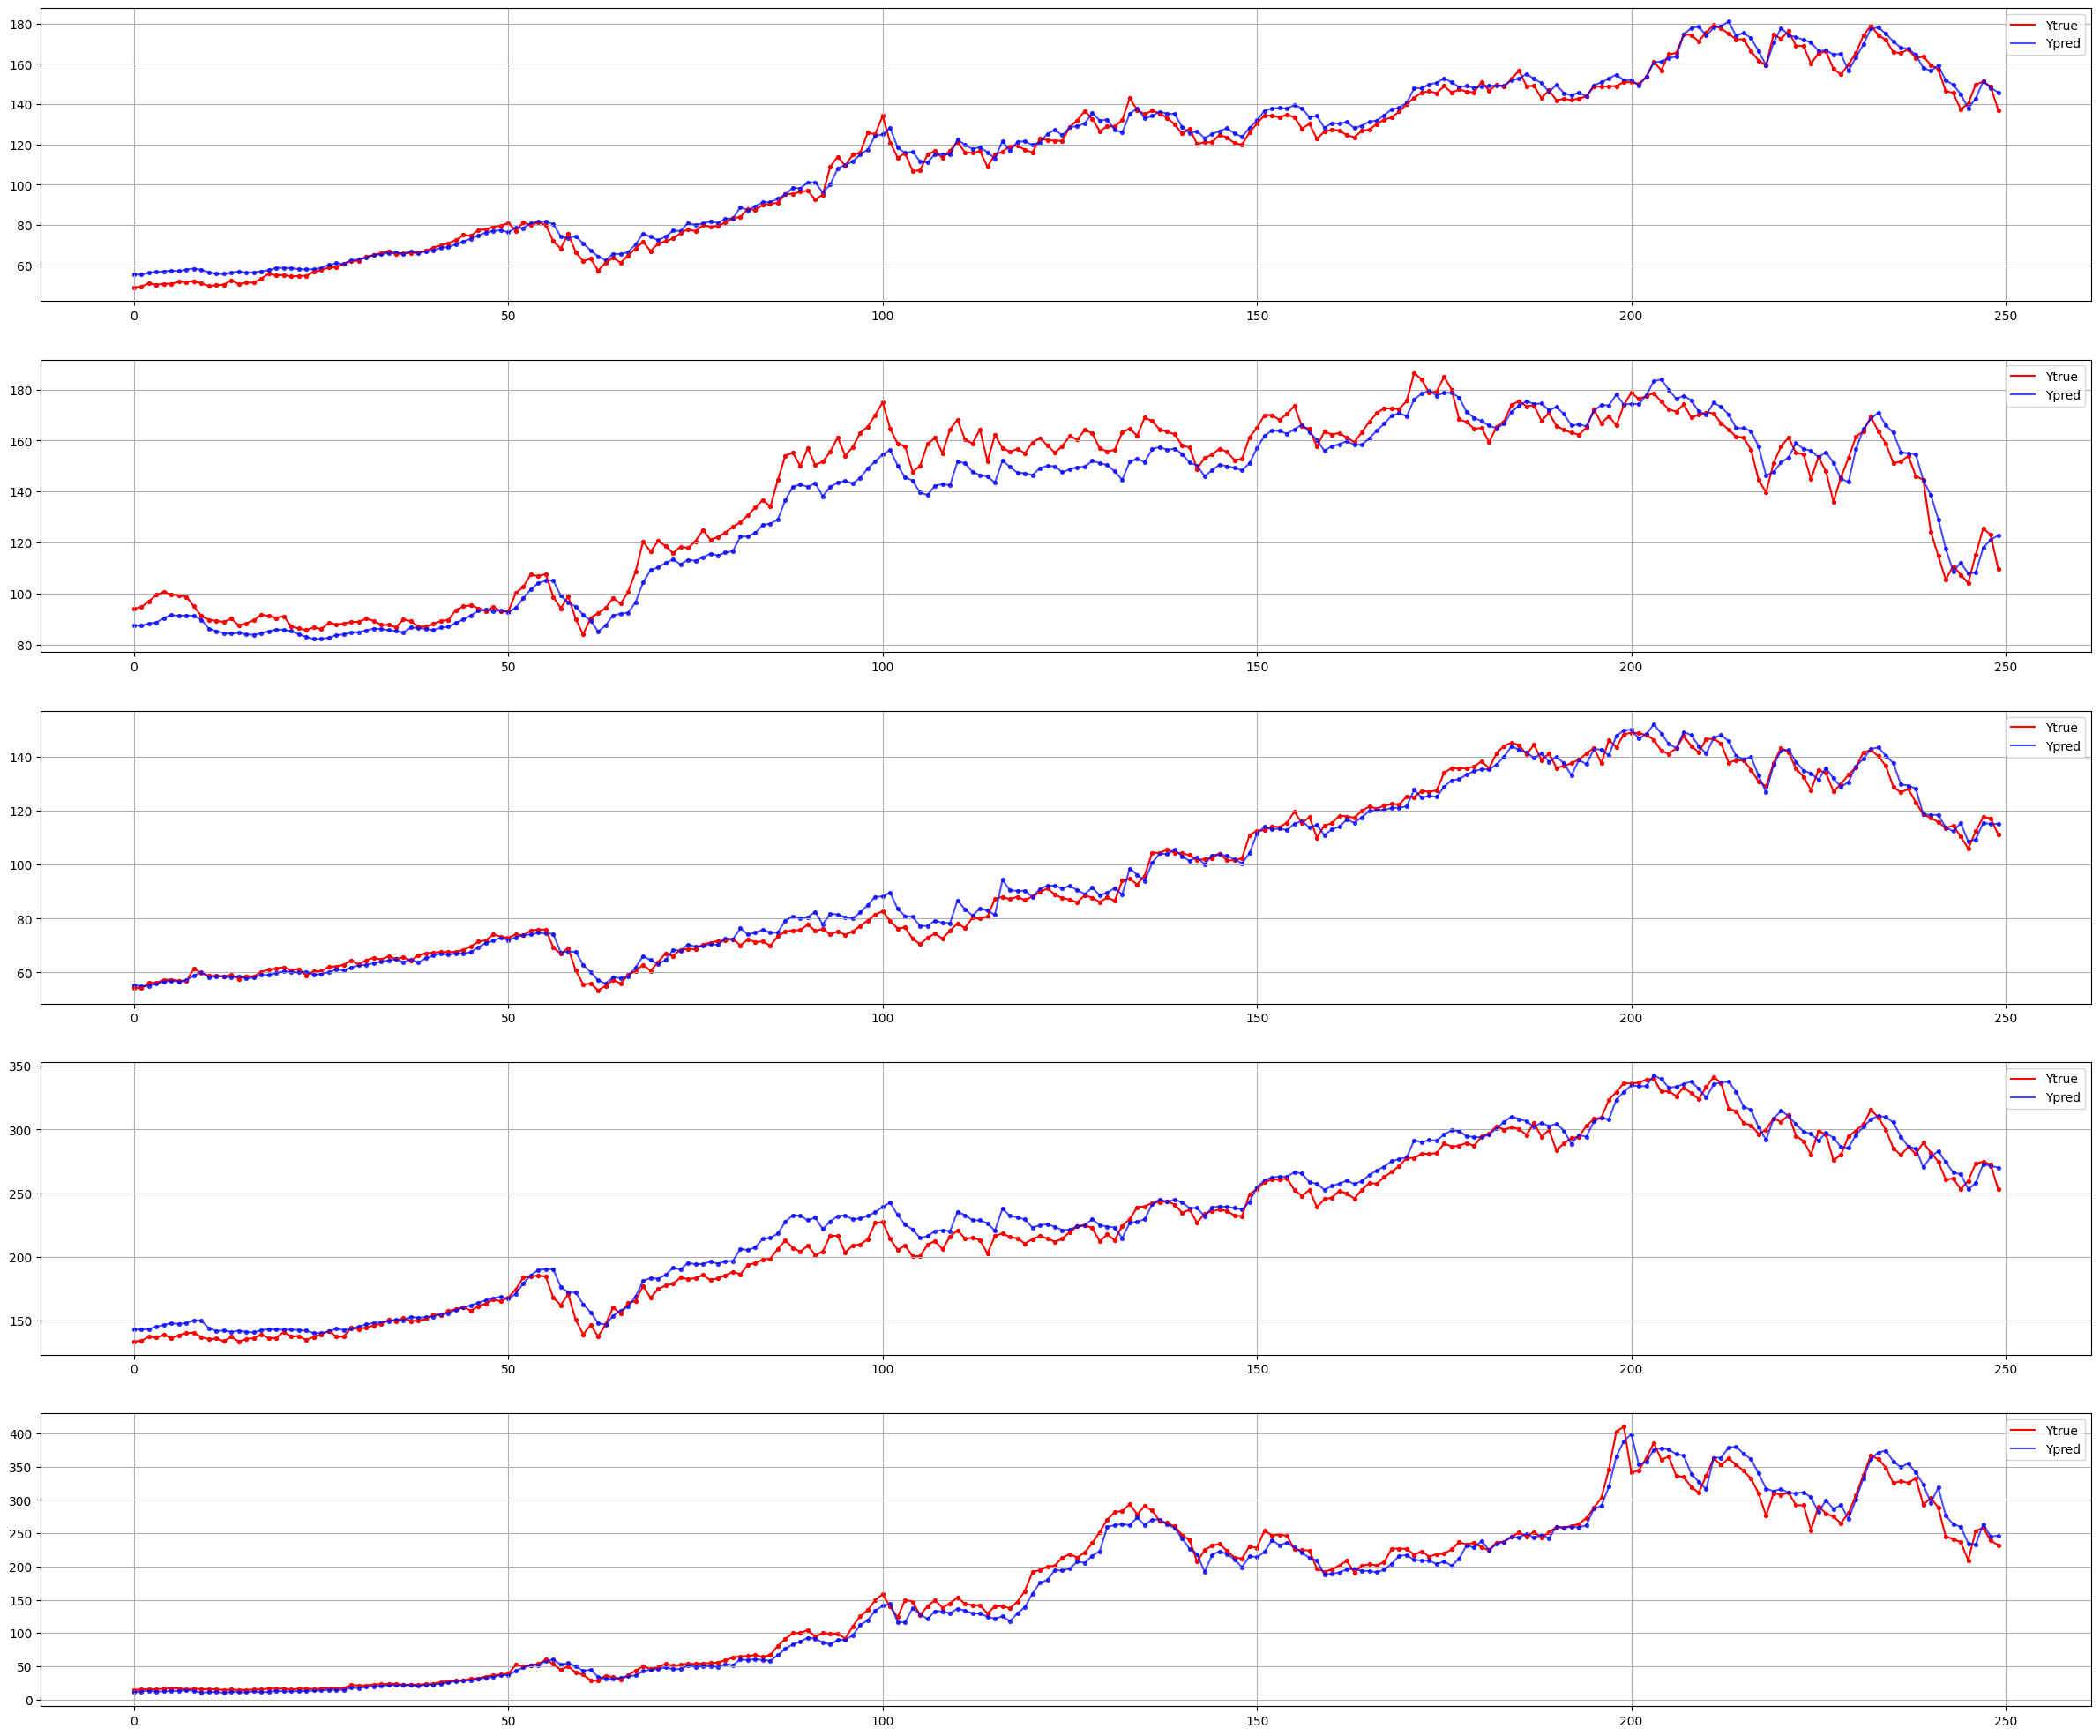

In [31]:
# Calculate percentage change
def pctc(arr):
  return np.diff(arr,axis = 0) / arr[:-1,:] * 100

# if convolution:
#     # Ypred = model.evaluate(model.data.X_test_set.tensor.unsqueeze(1)).numpy()
#     Ypred_pctc = model.evaluate(model.data.X_test_set.tensorT).numpy().copy()
# else:
#     Ypred_pctc = model.evaluate(model.data.X_test_set.reshaped_2D_tensor()).numpy().copy()
# Ytrue_pctc = model.data.Y_test_set.ndarray.copy()
# floorYtest = model.data.Ybis_test_set.ndarray.copy()

# Ypred= (Ypred_pctc/100.+1.)*floorYtest
# Ytrue= (Ytrue_pctc/100.+1.)*floorYtest
# ### it is very different from inverting pctc (since it guesses the future...)

if convolution:
    # Ypred = model.evaluate(model.data.X_test_set.tensor.unsqueeze(1)).numpy()
    Ypred = model.evaluate(model.data.X_test_set.tensorT).numpy().copy()*model.data.scal_buffer_test
else:
    Ypred= model.evaluate(model.data.X_test_set.reshaped_2D_tensor()).numpy().copy()*model.data.scal_buffer_test
Ytrue = model.data.Y_test_set.ndarray.copy()*model.data.scal_buffer_test

Ytrue_pctc = pctc(Ytrue)
Ypred_pctc = pctc(Ypred)

# Assuming Ypred and Ytrue are 2D arrays with shape (n_samples, n_curves)
n_curves = len(Ypred[0])
n_samples = len(Ypred)

t = np.arange(n_samples)

# Create a subplot
fig, ax = plt.subplots(n_curves,1,figsize=(30,25))

# Plot the first set (Ypred) in blue
for i in range(n_curves):
    ax[i].plot(t, Ytrue[:, i], color='red', label='Ytrue')
    ax[i].scatter(t, Ytrue[:, i], color='red', s= 8)
    ax[i].plot(t, Ypred[:, i], color='blue', label='Ypred',alpha = 0.7)
    ax[i].scatter(t, Ypred[:, i], color='blue', s= 8,alpha = 0.7)
    ax[i].legend()
    ax[i].grid()

Text(0, 0.5, 'Cumulative returns (%)')

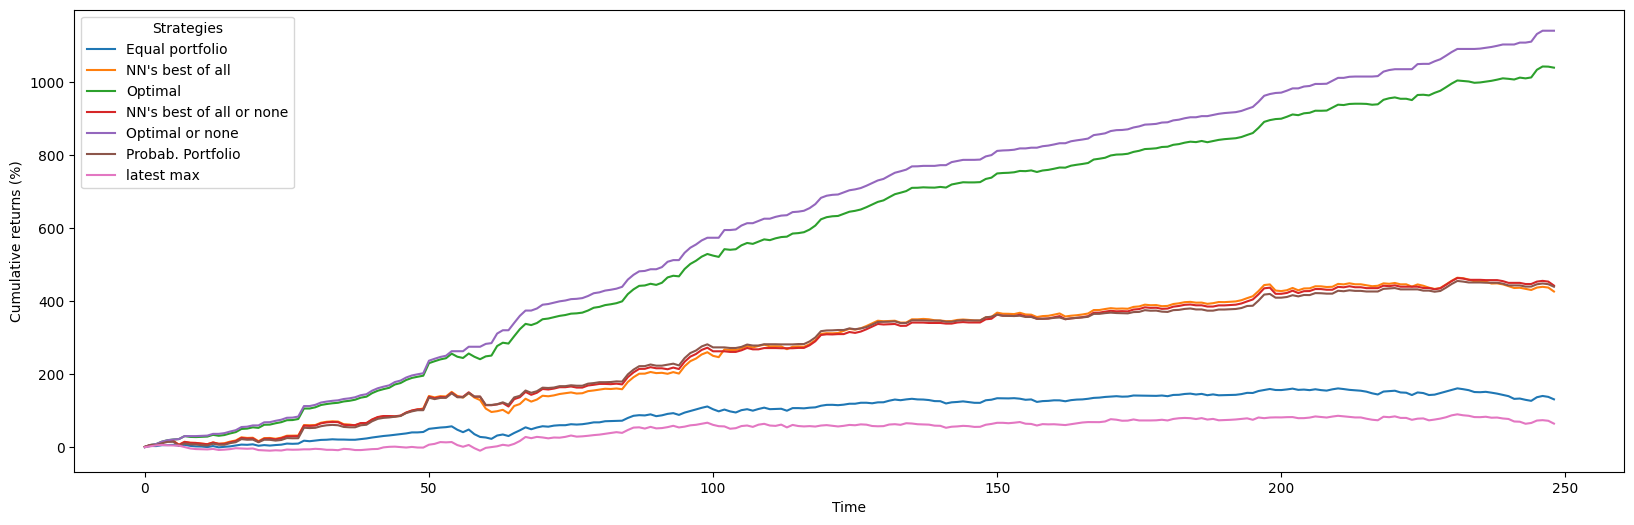

In [32]:
#### Return of the asset vs return on-off if up or down prediction.
import numpy as np

# PCa = pctc(Ytrue) #to be fixed because this misses a point... compared to sets....
PCa = Ytrue_pctc
# temp = pctc(Ypred) #same
temp = Ypred_pctc

PCmax = np.maximum.reduce(PCa,axis=1)
PCmax_and_cash = np.maximum(PCmax,0.0)

##
max_indices = np.argmax(temp, axis=1)

# PCb = PCa[:,max_indices]
PCb = PCa[np.arange(PCa.shape[0]), max_indices]

temp  = np.hstack((temp,np.zeros((temp.shape[0], 1))))
max_indices_with_zero = np.argmax(temp, axis=1)
PCa_and_cash = np.hstack((PCa,np.zeros((PCa.shape[0], 1))))

PCbBis = PCa_and_cash[np.arange(PCa_and_cash.shape[0]), max_indices_with_zero]

## naive portfolios
#if just having the same amount of each asset.
PCequal = np.sum(PCa,axis = 1)/len(PCa[0]) 
#if betting on the max of all and v 0

# temp2 = model.data.X_test_set.ndarray[:,-1,:]
temp2 = model.data.X_test_set.ndarray[1:,-1,:]
temp3 =  np.hstack((temp2,np.zeros((temp2.shape[0], 1))))
bestbefore = np.argmax(temp3,axis=1)

PCbestbefore_and_cash = PCa_and_cash[np.arange(PCa_and_cash.shape[0]),bestbefore]

### invest proportionally to pred
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

PC_portfolio = np.exp(temp)*(temp>=0.0)
# PC_portfolio = temp
PC_portfolio = PC_portfolio/np.sum(PC_portfolio,axis=1)[:,np.newaxis]
PC_portfolio = np.sum(PCa_and_cash*PC_portfolio,axis = 1)

# cumulate the pct changes
PCequal = PCequal.cumsum()
PCb = PCb.cumsum()
PCmax = PCmax.cumsum()
PCbBis = PCbBis.cumsum()
PCmax_and_cash = PCmax_and_cash.cumsum()
PC_portfolio = PC_portfolio.cumsum()
PCbestbefore_and_cash = PCbestbefore_and_cash.cumsum()
# Plot
fig = plt.figure(figsize=(20,6))
plt.plot(PCequal)
plt.plot(PCb)
plt.plot(PCmax)
plt.plot(PCbBis)
plt.plot(PCmax_and_cash)
plt.plot(PC_portfolio)
plt.plot(PCbestbefore_and_cash)
plt.legend(['Equal portfolio',"NN's best of all",'Optimal', "NN's best of all or none", 'Optimal or none','Probab. Portfolio', 'latest max'], title = 'Strategies')
plt.xlabel('Time')
plt.ylabel('Cumulative returns (%)')

Hyperparameters tuning

In [ ]:
import optuna 
from hypertune import create_objective
from plotly.io import show
import optuna.visualization as vis

In [ ]:

study = optuna.create_study(direction="minimize")
# study.enqueue_trial({'n_epochs': 20, 'conv_out_channels': 8, 'kernel_size': 7, 'linear1_units': 176})
objective = create_objective(model)


In [ ]:
#cell can be restarted if necessary and it will keep going
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)
print("Best validation loss: ", study.best_value)

# Plot the optimization history
fig = vis.plot_optimization_history(study)
show(fig)
# Plot the parameter importance
fig = vis.plot_param_importances(study)
show(fig)
